### This notebook forms Stage 1 of the project, focusing on cleaning, transforming, and preparing daily-level demand data from the FreshRetailNet‑50K dataset for downstream modeling. It builds upon the hourly data processed in earlier notebooks.

## ✅ Summary of Steps

### 1. Hourly → Daily Aggregation
We aggregated hourly sales (`hours_sale`) into `daily_sale` for each store–product–day combination. We also:
- Limited stockout analysis to working hours (6:00–22:00).
- Added a flag (`full_day_oos_6to22`) if a product was fully out-of-stock during working hours.

### 2. Anomaly Detection
To ensure data quality:
- We flagged rows where sales occurred despite full-day stockouts (`suspicious_sale_during_oos = 1`).
- These rows are retained for transparency and potential analysis.

### 3. Modeling Scope Reduction via Category Filtering
To make the forecasting pipeline scalable:
- We computed total sales per `third_category_id`.
- Chose the **top 92 categories** that cover **95% of total demand**.
- This reduced the number of models significantly while preserving performance and coverage.

### 4. Final Daily Dataset
The processed dataset:
- Contains 4.5 million+ rows.
- Includes all relevant external/contextual features (weather, holidays, discount).
- Includes flags for stockouts and anomalies.
- Is now ready to be split and modeled per `third_category_id`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Load Raw Dataset

In [2]:
from datasets import load_dataset
import pandas as pd

# Load the full dataset from Hugging Face
raw_ds = load_dataset("Dingdong-Inc/FreshRetailNet-50K", split="train")
df = pd.DataFrame(raw_ds)

# Inspect initial structure
print("Loaded dataset shape:", df.shape)
df.head()

/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded dataset shape: (4500000, 19)


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",8,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,0,0,3.5386,15.37,78.26,1.25


In [3]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from Hugging Face
ds = load_dataset("Dingdong-Inc/FreshRetailNet-50K", split="train")

# Convert to pandas DataFrame
df = ds.to_pandas()
print("✅ Loaded raw dataset:", df.shape)
# df.head()

✅ Loaded raw dataset: (4500000, 19)


In [4]:
import numpy as np

def flatten_hourly(df):
    n = len(df)
    flat_df = pd.DataFrame({
        'city_id': np.repeat(df['city_id'].values, 24),
        'store_id': np.repeat(df['store_id'].values, 24),
        'management_group_id': np.repeat(df['management_group_id'].values, 24),
        'first_category_id': np.repeat(df['first_category_id'].values, 24),
        'second_category_id': np.repeat(df['second_category_id'].values, 24),
        'third_category_id': np.repeat(df['third_category_id'].values, 24),
        'product_id': np.repeat(df['product_id'].values, 24),
        'dt': np.repeat(df['dt'].values, 24),
        'hour': list(range(24)) * n,
        'hourly_sale': np.concatenate(df['hours_sale'].values),
        'hourly_stockout': np.concatenate(df['hours_stock_status'].values),
        'discount': np.repeat(df['discount'].values, 24),
        'holiday_flag': np.repeat(df['holiday_flag'].values, 24),
        'activity_flag': np.repeat(df['activity_flag'].values, 24),
        'precpt': np.repeat(df['precpt'].values, 24),
        'avg_temperature': np.repeat(df['avg_temperature'].values, 24),
        'avg_humidity': np.repeat(df['avg_humidity'].values, 24),
        'avg_wind_level': np.repeat(df['avg_wind_level'].values, 24)
    })
    return flat_df

## Flatten Hourly Data (if still present)

In [5]:
import os

# Folder to store intermediate chunk files
os.makedirs("data/freshretail_flattened_chunks", exist_ok=True)

def flatten_hourly_in_chunks_to_disk(df, chunk_size=2000, output_folder="data/freshretail_flattened_chunks"):
    total_chunks = (len(df) + chunk_size - 1) // chunk_size
    for i in range(total_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))
        chunk = df.iloc[start_idx:end_idx]
        flattened = flatten_hourly(chunk)
        chunk_path = os.path.join(output_folder, f"flattened_chunk_{i:04d}.parquet")
        flattened.to_parquet(chunk_path, index=False)
        print(f"✅ Flattened rows {start_idx:,} to {end_idx-1:,} → Saved {len(flattened):,} rows → {chunk_path}")

flatten_hourly_in_chunks_to_disk(df, chunk_size=10000)

✅ Flattened rows 0 to 9,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0000.parquet
✅ Flattened rows 10,000 to 19,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0001.parquet
✅ Flattened rows 20,000 to 29,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0002.parquet
✅ Flattened rows 30,000 to 39,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0003.parquet
✅ Flattened rows 40,000 to 49,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0004.parquet
✅ Flattened rows 50,000 to 59,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0005.parquet
✅ Flattened rows 60,000 to 69,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0006.parquet
✅ Flattened rows 70,000 to 79,999 → Saved 240,000 rows → data/freshretail_flattened_chunks/flattened_chunk_0007.parquet
✅ Flattened rows 80,000 to 89,999 → Saved 240,

## Aggregate to Daily Level

In [6]:
import os
import pandas as pd

# Path to flattened hourly parquet chunks
chunk_dir = "data/freshretail_flattened_chunks"
files = sorted([f for f in os.listdir(chunk_dir) if f.endswith(".parquet")])

daily_chunks = []

for i, file in enumerate(files):
    df = pd.read_parquet(os.path.join(chunk_dir, file))
    df["dt"] = pd.to_datetime(df["dt"])

    # Aggregate across full 24 hours
    agg = df.groupby(
        ['city_id', 'store_id', 'management_group_id',
         'first_category_id', 'second_category_id', 'third_category_id',
         'product_id', 'dt']
    ).agg({
        'hourly_sale': 'sum',
        'hourly_stockout': 'sum',
        'discount': 'mean',
        'holiday_flag': 'max',
        'activity_flag': 'max',
        'precpt': 'mean',
        'avg_temperature': 'mean',
        'avg_humidity': 'mean',
        'avg_wind_level': 'mean'
    }).reset_index()

    # Rename for clarity
    agg.rename(columns={
        'hourly_sale': 'daily_sale',
        'hourly_stockout': 'oos_hours_total'
    }, inplace=True)

    # Flag for full-day stockout (24 hours)
    agg['full_day_oos'] = (agg['oos_hours_total'] == 24).astype(int)

    # Flag for suspicious sales during full-day stockout
    agg['suspicious_sale_during_oos'] = (
        (agg['daily_sale'] > 0) & (agg['full_day_oos'] == 1)
    ).astype(int)

    daily_chunks.append(agg)

    if i % 20 == 0:
        print(f"🧱 Aggregated chunk {i}/{len(files)} — daily rows so far ~{sum(len(c) for c in daily_chunks):,}")

# Final full daily DataFrame
daily_df = pd.concat(daily_chunks, ignore_index=True)
print("✅ Final daily dataframe:", daily_df.shape)
print("⚠️ Suspicious sale rows:", daily_df['suspicious_sale_during_oos'].sum())

🧱 Aggregated chunk 0/450 — daily rows so far ~10,000
🧱 Aggregated chunk 20/450 — daily rows so far ~210,000
🧱 Aggregated chunk 40/450 — daily rows so far ~410,000
🧱 Aggregated chunk 60/450 — daily rows so far ~610,000
🧱 Aggregated chunk 80/450 — daily rows so far ~810,000
🧱 Aggregated chunk 100/450 — daily rows so far ~1,010,000
🧱 Aggregated chunk 120/450 — daily rows so far ~1,210,000
🧱 Aggregated chunk 140/450 — daily rows so far ~1,410,000
🧱 Aggregated chunk 160/450 — daily rows so far ~1,610,000
🧱 Aggregated chunk 180/450 — daily rows so far ~1,810,000
🧱 Aggregated chunk 200/450 — daily rows so far ~2,010,000
🧱 Aggregated chunk 220/450 — daily rows so far ~2,210,000
🧱 Aggregated chunk 240/450 — daily rows so far ~2,410,000
🧱 Aggregated chunk 260/450 — daily rows so far ~2,610,000
🧱 Aggregated chunk 280/450 — daily rows so far ~2,810,000
🧱 Aggregated chunk 300/450 — daily rows so far ~3,010,000
🧱 Aggregated chunk 320/450 — daily rows so far ~3,210,000
🧱 Aggregated chunk 340/450 — da

### 🧠 Select Top Third-Level Categories
To simplify training:
- Compute total sales per `third_category_id`
- Select top 92 categories covering 95% of demand
- Reduces modeling complexity from 230+ categories

In [7]:
top_5_categories = daily_df['first_category_id'].value_counts().head(5).index.tolist()
print("Top 5 categories:", top_5_categories)

Top 5 categories: [4, 16, 20, 29, 8]


In [8]:
daily_df.to_parquet("data/fresh_retail_net_daily.parquet", index=True)
daily_df.to_csv("data/fresh_retail_net_daily.csv", index=True)

In [9]:
unique_third_categories = daily_df['third_category_id'].nunique()
print(f"✅ Number of unique third_category_id values: {unique_third_categories}")

✅ Number of unique third_category_id values: 233


In [10]:
category_sales = (
    daily_df.groupby('third_category_id')['daily_sale']
    .sum()
    .sort_values(ascending=False)
)
print("Top categories by total sales:")


Top categories by total sales:


In [11]:
top_categories = (
    daily_df.groupby('third_category_id')['daily_sale']
    .sum()
    .sort_values(ascending=False)
    .head()
    .index.tolist()
)

print("Top 5 third_category_ids by total sales:", top_categories)

Top 5 third_category_ids by total sales: [81, 184, 60, 82, 1]


In [12]:
filtered_df = daily_df[daily_df['third_category_id'].isin(top_categories)].copy()

In [13]:
print(daily_df.shape, filtered_df.shape)

(4500000, 19) (480060, 19)


In [14]:
category_sales = (
    daily_df.groupby('third_category_id')['daily_sale']
    .sum()
    .sort_values(ascending=False)
)
print("Top categories by total sales:")
print(len(category_sales))

Top categories by total sales:
233


In [15]:
cumulative_share = category_sales.cumsum() / category_sales.sum()
top_85 = cumulative_share[cumulative_share <= 0.85].index.tolist()
top_90 = cumulative_share[cumulative_share <= 0.90].index.tolist()
top_95 = cumulative_share[cumulative_share <= 0.95].index.tolist()
top_99 = cumulative_share[cumulative_share <= 0.99].index.tolist()

print(f"Top {len(top_85)} categories covering 85% of total sales.")
print(f"Top {len(top_90)} categories covering 90% of total sales.")
print(f"Top {len(top_95)} categories covering 95% of total sales.")
print(f"Top {len(top_99)} categories covering 99% of total sales.")

Top 58 categories covering 85% of total sales.
Top 72 categories covering 90% of total sales.
Top 92 categories covering 95% of total sales.
Top 139 categories covering 99% of total sales.


### 🚨 Flag Suspicious Sales During Full-Day Stockouts
Flag rows where products were sold (`daily_sale > 0`) despite full-day stockouts.
These are rare but retained for integrity (`suspicious_sale_during_oos`).

In [16]:
# import pandas as pd
# # First, ensure the hourly OOS hours are calculated from full range (0–23)
# full_day_df = pd.DataFrame()  # Optional if you haven't aggregated yet

# # Assuming you already have the flattened hourly data
# import os
# import pandas as pd

# chunk_dir = "freshretail_flattened_chunks"
# files = sorted([f for f in os.listdir(chunk_dir) if f.endswith(".parquet")])

# full_day_chunks = []
# for file in files:
#     df = pd.read_parquet(os.path.join(chunk_dir, file))
#     df["dt"] = pd.to_datetime(df["dt"])

#     agg = df.groupby(
#         ['city_id', 'store_id', 'management_group_id',
#          'first_category_id', 'second_category_id', 'third_category_id',
#          'product_id', 'dt']
#     ).agg({
#         'hourly_sale': 'sum',
#         'hourly_stockout': 'sum',
#         'discount': 'mean',
#         'holiday_flag': 'max',
#         'activity_flag': 'max',
#         'precpt': 'mean',
#         'avg_temperature': 'mean',
#         'avg_humidity': 'mean',
#         'avg_wind_level': 'mean'
#     }).reset_index()

#     agg.rename(columns={
#         'hourly_sale': 'daily_sale',
#         'hourly_stockout': 'oos_hours_0to23'
#     }, inplace=True)

#     # Flag full-day OOS across 24 hours
#     agg["full_day_oos_0to23"] = (agg["oos_hours_0to23"] == 24).astype(int)
#     full_day_chunks.append(agg)

# # Final dataframe
# df_full_oos = pd.concat(full_day_chunks, ignore_index=True)

# # Check for cases where sale > 0 despite full-day stockout
# suspicious_full_day_sales = df_full_oos[
#     (df_full_oos["full_day_oos_0to23"] == 1) &
#     (df_full_oos["daily_sale"] > 0)
# ]

# print(f"⚠️ Rows with full 24-hour stockout but positive sales: {len(suspicious_full_day_sales):,}")
# suspicious_full_day_sales.to_csv("suspicious_sales_full_day_oos.csv", index=False)
# print("💾 Saved to suspicious_sales_full_day_oos.csv")

In [17]:
# print("Ratio of suspicious rows to the full dataset:", round(suspicious_full_day_sales.shape[0]/df_full_oos.shape[0], 4))

In [18]:
# 1. Filter suspicious rows
suspicious_df = daily_df[
    (daily_df['suspicious_sale_during_oos'] == 1)
]

# 2. Get unique third_category_ids from suspicious rows
suspicious_third_categories = suspicious_df['third_category_id'].unique()
print(f"Suspicious third_category_ids: {suspicious_third_categories}")

# 3. Compare against your selected top categories
# (Replace this list with your actual selection)
selected_third_categories = [81, 184, 60, 82, 1]  # for example

# 4. Check overlap
overlap = set(suspicious_third_categories) & set(selected_third_categories)
print("✅ Overlapping third_category_ids in suspicious sales and selected top categories:")
print(overlap)

# Optional: How many suspicious rows fall into the selected top categories
num_suspicious_in_top = suspicious_df[
    suspicious_df['third_category_id'].isin(selected_third_categories)
].shape[0]
print(f"⚠️ Suspicious rows in selected top categories: {num_suspicious_in_top}")

Suspicious third_category_ids: [154 218 104  56   1 142 179  77 113 114  83 181 173  24  59 123 184 199
 195  17  94 103 111  81 180 156  72  58 116 190 205 216 160   6  66 109
 170  42 157 193  11  88  98 112  10 131 163 115 139  60  67 165 191 168
  65 217 149 229 172 231  82  97 146 161  16   9  46  89  71  74 145 177
  86  30  41 127  15  93 150  52 167 182 187 140 183 202 215 148 105 110
  99 100  76  38  44  91  18 223 228  48 212 141 194  51 209 133 164 224
 176 106   4  68 213  13 221 230  61  96 101  27  78  40  28  39 129   0
 121  87  19 200  63 126 166  31 192 204   3  54 147   2  29 128  37 186
 135 169  90  55   7 119  85 122 162 220  75 174 189  14 188 197 201  69
 151  62  57 153 225  32   8  79  47 227 130  35  36  70 120  26  33  80
 158  49]
✅ Overlapping third_category_ids in suspicious sales and selected top categories:
{1, 81, 82, 184, 60}
⚠️ Suspicious rows in selected top categories: 1893


### We’ll use time-based splitting to avoid data leakage.

### Since your data spans ~90 days:
- Use first ~75 days for training
- Use last 15 days for validation

In [19]:
# Step 1: Filter to top 58 third_category_ids
top_third_cats = daily_df['third_category_id'].value_counts(normalize=True).cumsum()
selected_cats = top_third_cats[top_third_cats <= 0.85].index.tolist()
filtered_df = daily_df[daily_df['third_category_id'].isin(selected_cats)].copy()

print("🎯 Filtered dataset shape:", filtered_df.shape)

# Step 2: Sort and split based on date
filtered_df["dt"] = pd.to_datetime(filtered_df["dt"])
filtered_df = filtered_df.sort_values("dt")
cutoff_date = filtered_df["dt"].max() - pd.Timedelta(days=15)

train_df = filtered_df[filtered_df["dt"] <= cutoff_date].copy()
val_df = filtered_df[filtered_df["dt"] > cutoff_date].copy()

# Info
print("✅ Train shape:", train_df.shape)
print("✅ Validation shape:", val_df.shape)
print("📅 Train date range:", train_df["dt"].min(), "→", train_df["dt"].max())
print("📅 Validation date range:", val_df["dt"].min(), "→", val_df["dt"].max())

🎯 Filtered dataset shape: (3819960, 19)
✅ Train shape: (3183300, 19)
✅ Validation shape: (636660, 19)
📅 Train date range: 2024-03-28 00:00:00 → 2024-06-10 00:00:00
📅 Validation date range: 2024-06-11 00:00:00 → 2024-06-25 00:00:00


In [20]:
# Create a directory to save daily data
import os
os.makedirs("data/daily_dataset", exist_ok=True)

# Save the full daily DataFrame
daily_df.to_parquet("data/daily_dataset/freshretail_daily.parquet", index=False)
print("✅ Saved daily-level dataset:", daily_df.shape)

✅ Saved daily-level dataset: (4500000, 19)


In [21]:
import pandas as pd

# Assume daily_df is already loaded and has columns ['third_category_id', 'daily_sale', ...]
# 1. Compute total sales per category
category_sales = (
    daily_df
    .groupby('third_category_id')['daily_sale']
    .sum()
    .sort_values(ascending=False)
)

# 2. Select top 10
top_10_categories = category_sales.head(10).index.tolist()
print("Top 10 third_category_ids by total sales:", top_10_categories)

Top 10 third_category_ids by total sales: [81, 184, 60, 82, 1, 24, 149, 154, 113, 123]


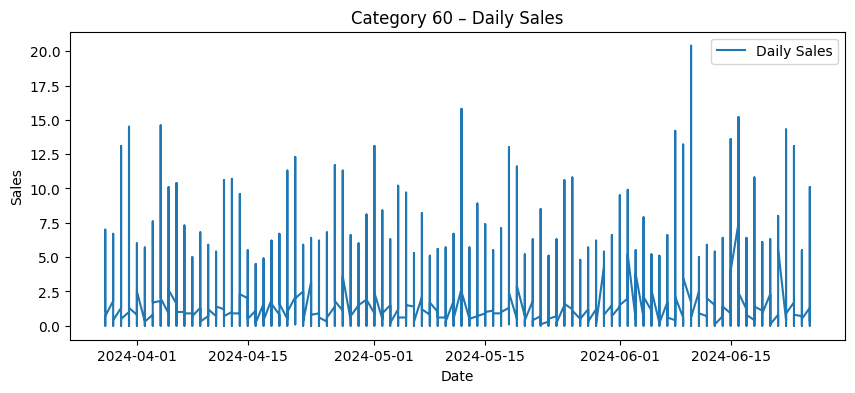

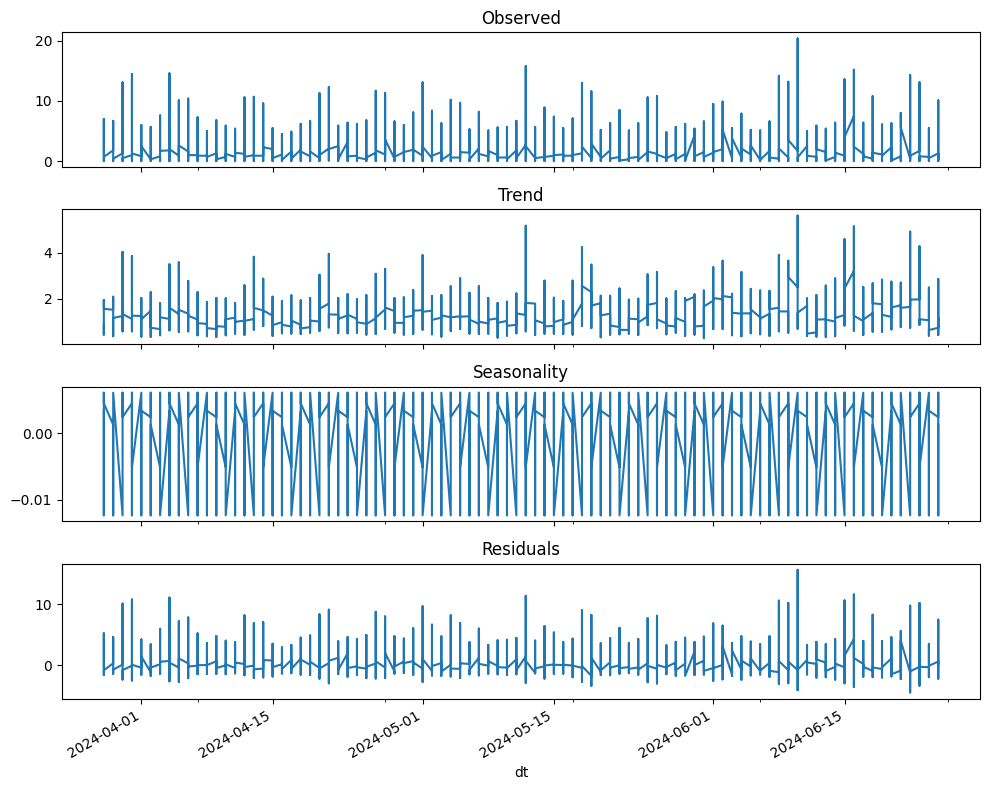

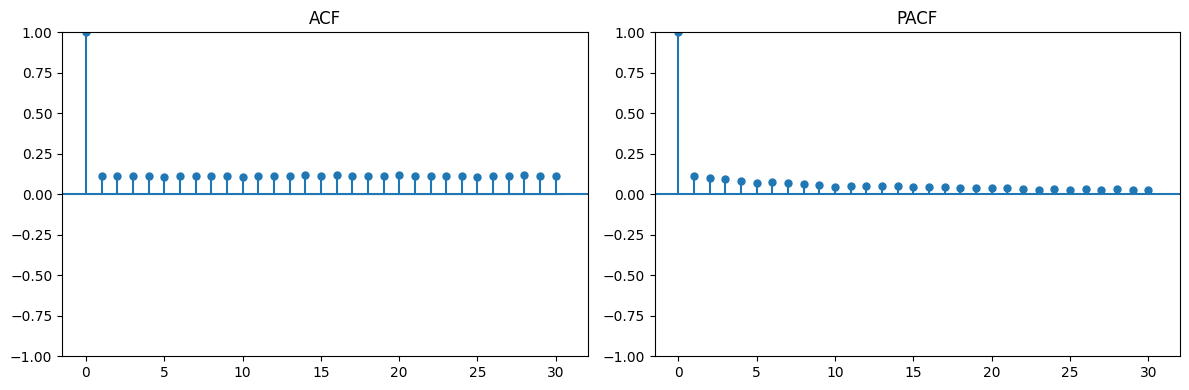

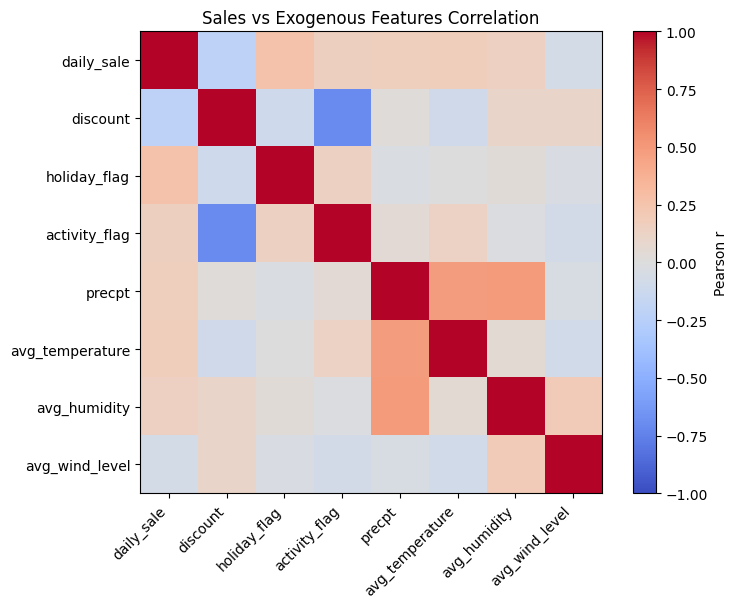

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the daily dataset
# daily_df = pd.read_parquet("data/daily_dataset/freshretail_daily.parquet")

# Pick a category for EDA
category_id = 60
df_cat = (
    daily_df
    .loc[daily_df["third_category_id"] == category_id]
    .sort_values("dt")
    .set_index("dt")
)

y = df_cat["daily_sale"]
exog_vars = ["discount", "holiday_flag", "activity_flag",
             "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"]
exog = df_cat[exog_vars]

# 1️⃣ Time Series Plot
plt.figure(figsize=(10,4))
plt.plot(y, label="Daily Sales")
plt.title(f"Category {category_id} – Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# 2️⃣ Weekly Seasonal Decomposition
decomp = seasonal_decompose(y, model="additive", period=7)
fig, axes = plt.subplots(4,1, figsize=(10,8), sharex=True)
decomp.observed.plot(ax=axes[0], title="Observed")
decomp.trend.plot(ax=axes[1], title="Trend")
decomp.seasonal.plot(ax=axes[2], title="Seasonality")
decomp.resid.plot(ax=axes[3], title="Residuals")
plt.tight_layout()
plt.show()

# 3️⃣ ACF & PACF (lags up to 30 days)
fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(y.fillna(0), lags=30, ax=axes[0]); axes[0].set_title("ACF")
plot_pacf(y.fillna(0), lags=30, ax=axes[1]); axes[1].set_title("PACF")
plt.tight_layout()
plt.show()

# 4️⃣ Correlation Matrix
corr = df_cat[["daily_sale"]+exog_vars].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr.index)
plt.colorbar(label="Pearson r")
plt.title("Sales vs Exogenous Features Correlation")
plt.show()